<font size="6"><b>Project Demo</b></font>

<font size="5">CSCI 4850-5850 - Neural Networks</font>

<font size="4">Due: May 2 @ 9:30am</font>

<font size="6">Nutritional Data to Ingredient Mass Guesser - Bread Recipes</font>

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import csv

# Add directory above current directory to path
import sys; sys.path.insert(0, '..')

from Generator import Generator
from RealData import RealData

<font size="5">All Parameters</font>

In [2]:
# For Generator
low = 1 
high = 100 
rank = False 
normalize = True

train_examples = 10000
test_examples = 100

# For Model
embed_dim = 2048 
stack = 6 
optimizer = keras.optimizers.Nadam() # Optimizer
loss = keras.losses.MSE # Regression Loss Function
metrics = keras.metrics.MeanSquaredError() # Metrics

# For Model Training
batch_size = 48
epochs = 1000
validation_split = 0.2
verbose = 0

2022-04-27 15:57:06.395253: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-27 15:57:06.395308: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-27 15:57:06.395351: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-tlm8n): /proc/driver/nvidia/version does not exist
2022-04-27 15:57:06.395706: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<font size="5">General Explanation</font>

The goal of this network is to be able to pass in bread recipes with their nutritional information, things such as calories or sodium, and the network tell us the main ingredients of that recipe with their masses in grams. To accomplish this, we have provided our network with the accurate values relating those ingredients to the nutritional items. Each is a sample of 100 grams. These values are shown below. They are all in grams for convenience and comparability.
<img src="images/nutrients.png">

<font size="5">Generator</font>

We took the list above and ran it through a generator we built to create thousands of random recipes to use as training data. These recipes could then be ranked or normalized to alter how the network would interpret them.

In [3]:
generator = Generator('../nutrients.csv') # filename with data
generator.generate(train_examples) # generates arg number of examples
generator.scale(low,high) # scales ingredients individually between min and max arg values
if rank:
    generator.rank()   
if normalize:
    generator.normalize()
    
generator.recipes.shape

(10000, 15, 13)

<font size="5">Model</font>

The model here uses stacked residual blocks to create a deep Network with skip connections.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 13)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 195)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 2048)         401408      flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2048)         4196352     dense[0][0]                      
______________________________________________________________________________________________

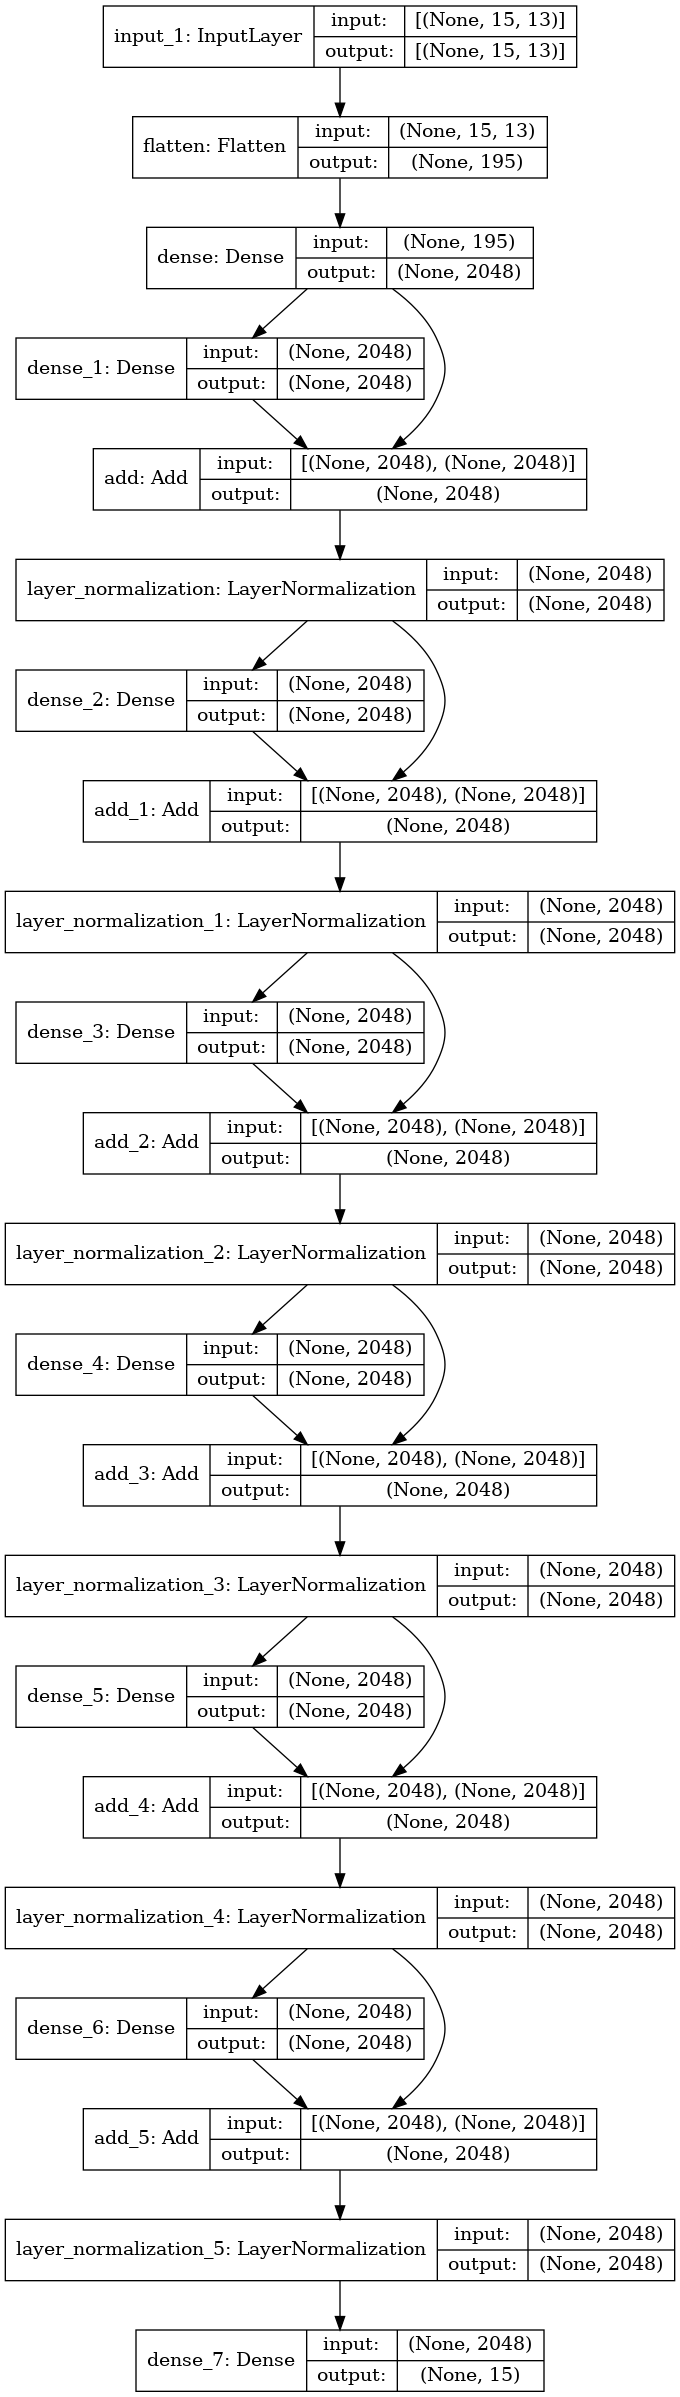

In [4]:
i1 = keras.layers.Input(generator.recipes.shape[1:])
f1 = keras.layers.Flatten()(i1)
y1 = keras.layers.Dense(embed_dim)(f1)

# Stack residual blocks (skip connections)
for _ in range(stack):
    y2 = y1
    y1 = keras.layers.Dense(embed_dim,
        activation=keras.activations.relu)(y1)
    y1 = keras.layers.Add()([y1,y2])
    y1 = keras.layers.LayerNormalization()(y1)

if normalize:
    o1 = keras.layers.Dense(generator.recipes.shape[1],activation=keras.activations.softplus)(y1)
    
else:
    o1 = keras.layers.Dense(generator.recipes.shape[1])(y1)
    
model = keras.Model(i1,o1)

model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

model.summary()
keras.utils.plot_model(model,show_shapes=True,expand_nested=True)

<font size="5">Model Training</font>

If you uncomment the fit function below and comment the model load function instead, you can run the model above in real time. You can also then see the plot of how the model trained if you run this live by uncommenting the plt section. However, this process could take quite a long time, as such, a pre-trained model has been prepared.

In [5]:
# history = model.fit(generator.recipes, generator.quant,batch_size=batch_size,epochs=epochs,
#                     validation_split = validation_split,verbose=verbose)

# plt.figure(1)
# # summarize history for accuracy
# plt.subplot(211)
# plt.plot(history.history['mean_squared_error'])
# plt.plot(history.history['val_mean_squared_error'])
# plt.plot(history.history['loss'])
# plt.ylabel('Progress')
# plt.xlabel('Epoch')
# plt.legend(['Training','Validation'],loc='upper right')

model = keras.models.load_model('../Project_Demo_Folder/model.h5')

<font size="5">Testing Fake Data</font>

In [6]:
#prediction values
test_gen = Generator('../nutrients.csv')
test_gen.generate(test_examples) # generates arg number of examples
test_gen.scale(low,high) # scales ingredients individually between min and max arg values
if rank:
    test_gen.rank()   
if normalize:
    test_gen.normalize()
    
test_recipes = test_gen.recipes
test_quant = test_gen.quant

score = model.evaluate(test_recipes, test_quant, verbose=1)

2022-04-27 15:57:15.494103: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


4/4 [==============================] - 1s 20ms/step - loss: 1.6982 - mean_squared_error: 1.6982


In [7]:
pred = model.predict(test_recipes)
if normalize:
    pred = test_gen.inv_normalize(pred)
    
actual = test_gen.quant
if normalize:
    actual = test_gen.inv_normalize(actual)

In [8]:
# Change this value to anything within the amount of 
# test_examples you specified in the parameter block above
testing_index = 0 
# Then rerun this block

ingredientsList =['Active Dry Yeast','Water','Salt','Bread Flour','Butter','Sugar','Egg','Dry Milk',
                  'Whole Wheat Flour','Vegetable Oil','Olive Oil','Honey','Brown Sugar','All-Purpose Flour','Milk']

print(f"Fake Recipe #{testing_index+1}\n")
print(f"{ingredientsList[0].ljust(20)} - predicted: {str(round(pred[testing_index,0],3)).ljust(6)} grams | actual: {str(round(actual[testing_index,0],3)).ljust(6)} grams ")
print(f"{ingredientsList[1].ljust(20)} - predicted: {str(round(pred[testing_index,1],3)).ljust(6)} grams | actual: {str(round(actual[testing_index,1],3)).ljust(6)} grams ")
print(f"{ingredientsList[2].ljust(20)} - predicted: {str(round(pred[testing_index,2],3)).ljust(6)} grams | actual: {str(round(actual[testing_index,2],3)).ljust(6)} grams ")
print(f"{ingredientsList[3].ljust(20)} - predicted: {str(round(pred[testing_index,3],3)).ljust(6)} grams | actual: {str(round(actual[testing_index,3],3)).ljust(6)} grams ")
print(f"{ingredientsList[4].ljust(20)} - predicted: {str(round(pred[testing_index,4],3)).ljust(6)} grams | actual: {str(round(actual[testing_index,4],3)).ljust(6)} grams ")
print(f"{ingredientsList[5].ljust(20)} - predicted: {str(round(pred[testing_index,5],3)).ljust(6)} grams | actual: {str(round(actual[testing_index,5],3)).ljust(6)} grams ")
print(f"{ingredientsList[6].ljust(20)} - predicted: {str(round(pred[testing_index,6],3)).ljust(6)} grams | actual: {str(round(actual[testing_index,6],3)).ljust(6)} grams ")
print(f"{ingredientsList[7].ljust(20)} - predicted: {str(round(pred[testing_index,7],3)).ljust(6)} grams | actual: {str(round(actual[testing_index,7],3)).ljust(6)} grams ")
print(f"{ingredientsList[8].ljust(20)} - predicted: {str(round(pred[testing_index,8],3)).ljust(6)} grams | actual: {str(round(actual[testing_index,8],3)).ljust(6)} grams ")
print(f"{ingredientsList[9].ljust(20)} - predicted: {str(round(pred[testing_index,9],3)).ljust(6)} grams | actual: {str(round(actual[testing_index,9],3)).ljust(6)} grams ")
print(f"{ingredientsList[10].ljust(20)} - predicted: {str(round(pred[testing_index,10],3)).ljust(6)} grams | actual: {str(round(actual[testing_index,10],3)).ljust(6)} grams ")
print(f"{ingredientsList[11].ljust(20)} - predicted: {str(round(pred[testing_index,11],3)).ljust(6)} grams | actual: {str(round(actual[testing_index,11],3)).ljust(6)} grams ")
print(f"{ingredientsList[12].ljust(20)} - predicted: {str(round(pred[testing_index,12],3)).ljust(6)} grams | actual: {str(round(actual[testing_index,12],3)).ljust(6)} grams ")
print(f"{ingredientsList[13].ljust(20)} - predicted: {str(round(pred[testing_index,13],3)).ljust(6)} grams | actual: {str(round(actual[testing_index,13],3)).ljust(6)} grams ")
print(f"{ingredientsList[14].ljust(20)} - predicted: {str(round(pred[testing_index,14],3)).ljust(6)} grams | actual: {str(round(actual[testing_index,14],3)).ljust(6)} grams ")

Fake Recipe #1

Active Dry Yeast     - predicted: 6.567  grams | actual: 62.558 grams 
Water                - predicted: 2.971  grams | actual: 68.558 grams 
Salt                 - predicted: 44.988 grams | actual: 83.497 grams 
Bread Flour          - predicted: 3.11   grams | actual: 88.704 grams 
Butter               - predicted: 5.171  grams | actual: 26.245 grams 
Sugar                - predicted: 3.101  grams | actual: 11.91  grams 
Egg                  - predicted: 9.863  grams | actual: 97.485 grams 
Dry Milk             - predicted: 14.799 grams | actual: 97.584 grams 
Whole Wheat Flour    - predicted: 3.002  grams | actual: 12.83  grams 
Vegetable Oil        - predicted: 6.635  grams | actual: 81.913 grams 
Olive Oil            - predicted: 3.14   grams | actual: 14.949 grams 
Honey                - predicted: 4.139  grams | actual: 22.414 grams 
Brown Sugar          - predicted: 3.223  grams | actual: 2.97   grams 
All-Purpose Flour    - predicted: 3.104  grams | actual: 81.5

<font size="5">Testing Real Data</font>

In [9]:
data = list(csv.reader(open('../Project_Demo_Folder/Recipe_Data.csv')))
data = np.array(data)

In [10]:
recipe_quant = "../Recipe_Data.csv"
ingr_nutr = "../nutrients.csv"

realdata = RealData(recipe_quant,ingr_nutr)
if normalize:
    realdata.normalize()
    
pred = model.predict(realdata.recipes)
if normalize:
    pred = realdata.inv_normalize(pred)

For testing purposes, we have gathered a small list of recipes with the proper amounts of ingredients so we can accurately test our network.
<img src="images/recipes.png">

In [11]:
# Change this value to an index of a recipe above
testing_index = 1
# Then rerun this block

ingredientsList = ['Active Dry Yeast','Water','Salt','Bread Flour','Butter','Sugar','Egg','Dry Milk',
                  'Whole Wheat Flour','Vegetable Oil','Olive Oil','Honey','Brown Sugar','All-Purpose Flour','Milk']
recipeNames = ['invalid','Traditional White Bread','Country White Bread','Sourdough Starter','French Countryside Bread',
               'Italian Herb Bread','White Bread','100% Whole Wheat Bread','Dough','Bagel dough',
               'Bread Pretzel','Butter Rolls','Pizza Crust']

print(f"Recipe - {recipeNames[testing_index]}\n")
print(f"{ingredientsList[0].ljust(20)} - predicted: {str(round(pred[testing_index,0],3)).ljust(6)} grams | actual: {data[testing_index,1].ljust(6)} grams")
print(f"{ingredientsList[1].ljust(20)} - predicted: {str(round(pred[testing_index,1],3)).ljust(6)} grams | actual: {data[testing_index,2].ljust(6)} grams")
print(f"{ingredientsList[2].ljust(20)} - predicted: {str(round(pred[testing_index,2],3)).ljust(6)} grams | actual: {data[testing_index,3].ljust(6)} grams")
print(f"{ingredientsList[3].ljust(20)} - predicted: {str(round(pred[testing_index,3],3)).ljust(6)} grams | actual: {data[testing_index,4].ljust(6)} grams")
print(f"{ingredientsList[4].ljust(20)} - predicted: {str(round(pred[testing_index,4],3)).ljust(6)} grams | actual: {data[testing_index,5].ljust(6)} grams")
print(f"{ingredientsList[5].ljust(20)} - predicted: {str(round(pred[testing_index,5],3)).ljust(6)} grams | actual: {data[testing_index,6].ljust(6)} grams")
print(f"{ingredientsList[6].ljust(20)} - predicted: {str(round(pred[testing_index,6],3)).ljust(6)} grams | actual: {data[testing_index,7].ljust(6)} grams")
print(f"{ingredientsList[7].ljust(20)} - predicted: {str(round(pred[testing_index,7],3)).ljust(6)} grams | actual: {data[testing_index,8].ljust(6)} grams")
print(f"{ingredientsList[8].ljust(20)} - predicted: {str(round(pred[testing_index,8],3)).ljust(6)} grams | actual: {data[testing_index,9].ljust(6)} grams")
print(f"{ingredientsList[9].ljust(20)} - predicted: {str(round(pred[testing_index,9],3)).ljust(6)} grams | actual: {data[testing_index,10].ljust(6)} grams")
print(f"{ingredientsList[10].ljust(20)} - predicted: {str(round(pred[testing_index,10],3)).ljust(6)} grams | actual: {data[testing_index,11].ljust(6)} grams")
print(f"{ingredientsList[11].ljust(20)} - predicted: {str(round(pred[testing_index,11],3)).ljust(6)} grams | actual: {data[testing_index,12].ljust(6)} grams")
print(f"{ingredientsList[12].ljust(20)} - predicted: {str(round(pred[testing_index,12],3)).ljust(6)} grams | actual: {data[testing_index,13].ljust(6)} grams")
print(f"{ingredientsList[13].ljust(20)} - predicted: {str(round(pred[testing_index,13],3)).ljust(6)} grams | actual: {data[testing_index,14].ljust(6)} grams")
print(f"{ingredientsList[14].ljust(20)} - predicted: {str(round(pred[testing_index,14],3)).ljust(6)} grams | actual: {data[testing_index,15].ljust(6)} grams")

Recipe - Traditional White Bread

Active Dry Yeast     - predicted: 2.729  grams | actual: 5.6    grams
Water                - predicted: 3650.448 grams | actual: 236    grams
Salt                 - predicted: 284.177 grams | actual: 8.6    grams
Bread Flour          - predicted: 1411.217 grams | actual: 408    grams
Butter               - predicted: 666.752 grams | actual: 14     grams
Sugar                - predicted: 1099.513 grams | actual: 12.6   grams
Egg                  - predicted: 900.998 grams | actual: 0      grams
Dry Milk             - predicted: 366.968 grams | actual: 8.48   grams
Whole Wheat Flour    - predicted: 1266.33 grams | actual: 0      grams
Vegetable Oil        - predicted: 55.002 grams | actual: 0      grams
Olive Oil            - predicted: 35.128 grams | actual: 0      grams
Honey                - predicted: 78.098 grams | actual: 0      grams
Brown Sugar          - predicted: 149.858 grams | actual: 0      grams
All-Purpose Flour    - predicted: 281.129 gr